# Modeling and Evaluation

## 1. Notebook Overview

This notebook builds, tunes, and evaluates machine learning models for employee attrition prediction using the cleaned dataset and the saved preprocessing pipeline from the previous notebook.

The focus here is on interpretability. Logistic Regression is used as the primary model because it's straightforward to explain and interpret, making it the perfect choice for understanding what factors most strongly influence attrition.

Specifically, this notebook:

- Loads the cleaned dataset (`data_01.csv`)
- Loads the saved preprocessing pipeline (`preprocessing_pipeline.pkl`)
- Applies the transformations defined during preprocessing via the pipeline (feature engineering, encoding, scaling)
- Trains and evaluates a Logistic Regression classifier
- Assesses performance using both cross-validation and test set metrics
- Interprets results using explainability techniques to highlight drivers of attrition

In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import joblib
from sklearn.base import BaseEstimator, TransformerMixin

## 2. Load Dataset and Preprocessing Pipeline

- Load `data_01.csv` (unaltered clean dataset)
- Load `preprocessing_pipeline.pkl` using `joblib`
- Confirm compatibility and inspect sample rows

In [7]:
# Load dataset and preprocessing pipeline

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Replace with the exact same logic you used during preprocessing
        return X  # Placeholder


# Load the unaltered clean dataset
df = pd.read_csv('../data/processed/data_01.csv')

# Load the saved preprocessing pipeline
preprocessing_pipeline = joblib.load('../models/preprocessing_pipeline.pkl')

# Confirm structure of raw data
print("Shape of data_01.csv:", df.shape)
display(df.head())

# Check pipeline input compatibility
# Extract the list of expected input features from the pipeline
# by running a transform on a few rows and catching errors early
try:
    preprocessing_pipeline.transform(df.drop(columns='Attrition').head(3))
    print("Pipeline is compatible with current data")
except Exception as e:
    import traceback
    print("Pipeline check failed.")
    traceback.print_exc()

Shape of data_01.csv: (1470, 31)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


Pipeline check failed.


Traceback (most recent call last):
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\pipeline.py", line 54, in _raise_or_warn_if_not_fitted
    yield
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\pipeline.py", line 1092, in transform
    Xt = transform.transform(Xt, **routed_params[name].transform)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\utils\_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\compose\_column_transformer.py", line 1060, in transform
    check_is_fitted(self)
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\utils\validation.py", line 1757, in check_is_fitted
    raise NotFittedError(msg % {"name": type(es

## 3. Train-Test Split

- Separate features (`X`) and target (`y`)
- Perform stratified train-test split (preserving class distribution)
- Reserve test set exclusively for final evaluation

Train shape: (1176, 30), Test shape: (294, 30)

Target distribution in training set:
Attrition
No     0.838
Yes    0.162
Name: proportion, dtype: float64

Target distribution in test set:
Attrition
No     0.84
Yes    0.16
Name: proportion, dtype: float64


C:\Users\justi\AppData\Local\Temp\ipykernel_2872\1038712393.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, ax=axes[0], palette='pastel')
C:\Users\justi\AppData\Local\Temp\ipykernel_2872\1038712393.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, ax=axes[1], palette='pastel')


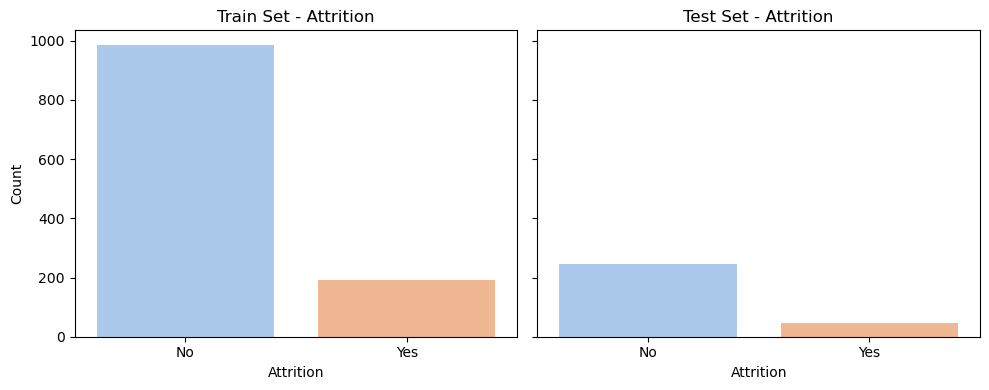

In [3]:
# Separate features and target
X = df.drop(columns='Attrition')
y = df['Attrition']

# Perform stratified train-test split (preserving class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Restore column names after train-test split
x_train = pd.DataFrame(X_train, columns=df.drop(columns='Attrition').columns)
x_test = pd.DataFrame(X_test, columns=df.drop(columns='Attrition').columns)

# Confirm shape
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Check class distribution numerically
print("\nTarget distribution in training set:")
print(y_train.value_counts(normalize=True).round(3))
print("\nTarget distribution in test set:")
print(y_test.value_counts(normalize=True).round(3))

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.countplot(x=y_train, ax=axes[0], palette='pastel')
axes[0].set_title("Train Set - Attrition")
axes[0].set_xlabel("Attrition")
axes[0].set_ylabel("Count")

sns.countplot(x=y_test, ax=axes[1], palette='pastel')
axes[1].set_title("Test Set - Attrition")
axes[1].set_xlabel("Attrition")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [6]:
# Get columns expected by pipeline
print("Pipeline expects:", preprocessing_pipeline.feature_names_in_)

# Get current columns in training data
print("x_train columns:", x_train.columns.tolist())

# Compare differences
print("Missing in x_train:", set(preprocessing_pipeline.feature_names_in_) - set(x_train.columns))
print("Extra in x_train:", set(x_train.columns) - set(preprocessing_pipeline.feature_names_in_))

AttributeError: 'FeatureEngineer' object has no attribute 'feature_names_in_'

## 4. Build Full Modeling Pipeline

- Append `LogisticRegression` to the preprocessing pipeline
- Define complete pipeline for modeling and evaluation

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Append model to preprocessing pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),  # from joblib
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

print("Full modeling pipeline successfully created.")

Full modeling pipeline successfully created.


## 5. Cross-Validation and Hyperparameter Tuning

- Use `GridSearchCV` or `Optuna` to tune model hyperparameters
- Train and cross-validate on the full training set
- Evaluate model performance using cross-validation metrics
- Save the best-performing model pipeline

In [5]:
# Define parameter grid for LogisticRegression
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs', 'liblinear']
}

# Append model to saved preprocessing pipeline
model_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on training data
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC score (cross-validated):", round(grid_search.best_score_, 3))

# Save the best model pipeline
joblib.dump(grid_search.best_estimator_, '../models/final_model_pipeline.pkl')
print("Best model pipeline saved.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7096, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'TenureCategory'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\utils\_indexing.py", line 364, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\pandas\core\indexes\base.py", line 3819, in get_loc
    raise KeyError(key) from err
KeyError: 'TenureCategory'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\pipeline.py", line 730, in fit_transform
    return last_step.fit_transform(
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\utils\_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\compose\_column_transformer.py", line 993, in fit_transform
    self._validate_column_callables(X)
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\compose\_column_transformer.py", line 552, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\justi\Anaconda3\envs\ibm-attrition-env\Lib\site-packages\sklearn\utils\_indexing.py", line 372, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


## 6. Final Model Evaluation on Test Set

- Predict on the untouched test set
- Evaluate with metrics:
  - Accuracy
  - Precision
  - Recall
  - F1-score
  - ROC-AUC
- Plot confusion matrix and ROC curve

## 7. Model Explainability

- Apply SHAP and/or LIME for feature attribution
- Visualize global feature importance
- Analyze individual predictions and edge cases
- Identify key drivers of attrition risk

## 8. Business Insights and Final Summary

- Summarize key model performance findings
- Highlight most impactful features influencing attrition
- Provide actionable recommendations
- Suggest next steps for model deployment or refinement